## Determining the separation on the sky for the matches between pristine and other catalogues

Making a plot of the separation in the matching for each of the Pristine X other catalogue. Then performing a cut based on the approximately log-normal median and median absolute deviation, such that all the matches are within the median +/- 3*MAD. The Intersection of all these catalogues is then compiled and written to a new table. The catalogues are 2MASS, SDSS, DESI Legacy, Gaia, CFIS/UNIONS, Pan-STARRS dr1 & dr3, and, of course, Pristine.

In [1]:
import pandas as pd
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from statsmodels import robust
from scipy.stats import mode

Measuring the speed at which these files download

In [2]:
%%time
hdu = fits.open('/arc/home/aydanmckay/phottable-x-lamost-pre-edit.fits')
data = hdu[1].data

CPU times: user 291 ms, sys: 43.6 ms, total: 335 ms
Wall time: 439 ms


In [3]:
len(data['ra'])

1000653

#### Separation Parameters:
angDist_1: Separation between LAMOST dr8 and Gaia edr3 \
Separation_1: Separation between Pristine and Gaia+LAMOST \
angDist_2: Separation between Pristine and 2MASS \
Separation_1a: Separation between 2MASS and Pristine+Gaia+LAMOST \
Separation_2: Separation between Pristine and CFIS/UNIONS \
Separation_1b: Separation between CFIS and Pristine+Gaia+LAMOST+2MASS \
Separation_2a: Separation between Pristine and Pan-STARRS dr3 \
Separation_1c: Separation between Pan-STARRS dr3 and Pristine+Gaia+LAMOST+2MASS+CFIS \
Separation_2b: Separation between Pristine and DESI Legacy \
Separation_1d: Separation between Legacy and Pristine+Gaia+LAMOST+2MASS+CFIS+Pan3 \
angDist_1a: Separation between Pristine and SDSS Photobjs dr17 \
Separation_1e: Separation between SDSS and Pristine+Gaia+LAMOST+2MASS+CFIS+Pan3+DESI \
angDist_2a: Separation between Pristine and Pan-STARRS dr1 \
Separation: Separation between Pan-STARRS dr1 and Pristine+Gaia+LAMOST+2MASS+CFIS+Pan3+DESI+SDSS

In [4]:
# Creating lists to save the medians and MADs for making cuts later
seps = [['angDist_2','2MASS'],['angDist_1a','SDSS'],['Separation_2b','DESI Legacy'],['Separation_1','Gaia+LAMOST'],['Separation_2','CFIS'],['angDist_2a','Pan-STARRS DR1']]
mads = np.zeros((6,1))
meds = np.zeros((6,1))

Plotting the separation between the matched sources.

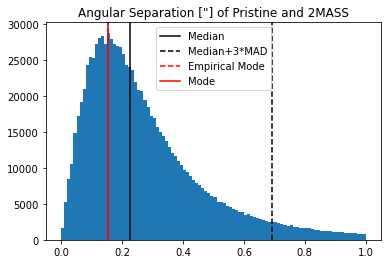

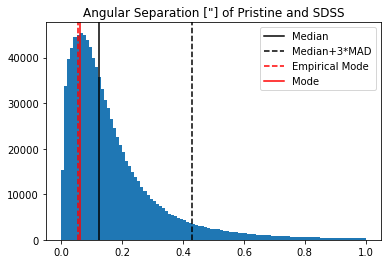

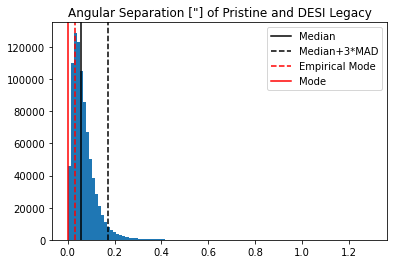

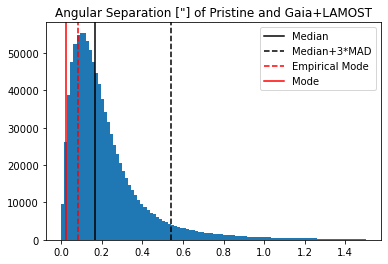

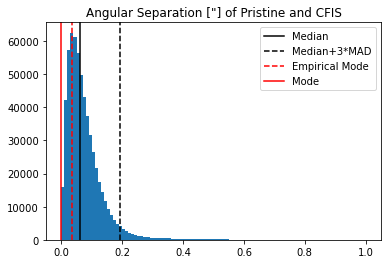

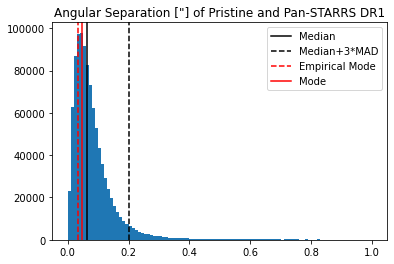

In [5]:
for it,sep in enumerate(seps):    
    # Creating the histogram of the separation values
    histo = plt.hist(data[sep[0]],bins=100)
    plt.title('Angular Separation [\"] of Pristine and '+sep[1])
    # Determining the median
    median = np.nanmedian(data[sep[0]])
    meds[it] += median
    plt.axvline(median,c='k',label='Median')
    # Determining the Median Absolute Deviation
    mad = robust.mad(data[sep[0]][np.isnan(data[sep[0]]) == False])
    mads[it] += mad
    plt.axvline(median+3*mad,c='k',linestyle='dashed',label=r'Median+3*MAD')
    # Determining the empirically derived mode
    empmode = 2.5*np.nanmedian(data[sep[0]]) - 1.5*np.nanmean(data[sep[0]])
    plt.axvline(empmode,c='r',linestyle='dashed',label='Empirical Mode')
    # Determining the actual mode
    dermode = mode(data[sep[0]][np.isnan(data[sep[0]]) == False])
    plt.axvline(dermode[0],c='r',label='Mode')
    plt.legend(fancybox=True)
    plt.show()

So it looks like we're missing a parameter from the log normal distribution in order to properly fit the data. It could also be a result of how the fit is matched to the bins. I tried the bin middles and that seemed more off than the bin ends, so theres some research to be done there. \
We don't want to be curve fitting I guess, just want to use the raw statistics and obtain the median and the MAD. \
Some of the calculated modes seemed to be quite off as clearly the mode wouldn't be a zero. Therefore we'll stick with the median and that cut for now.

In [48]:
mdata = data.copy()

In [49]:
for it,sep in enumerate(seps):
    mask = (mdata[sep[0]] < (meds[it]+3*mads[it])) | (np.isnan(mdata[sep[0]]) == True)
    mdata = mdata[mask]

So now we're dealing with datafi as the table and we can remove every entry that doesn't have a separation in any table.

Making the intersection mask

In [50]:
# Making sure that a value exists for every one of the matches
mask = (np.isnan(mdata[seps[0][0]]) == False) & (np.isnan(mdata[seps[1][0]]) == False) & (np.isnan(mdata[seps[2][0]]) == False) & \
       (np.isnan(mdata[seps[3][0]]) == False) & (np.isnan(mdata[seps[4][0]]) == False) & (np.isnan(mdata[seps[5][0]]) == False) & \
       (mdata['snrg'] > 20) & (mdata['TEFF_PASTEL'] > 0) & (mdata['TEFF_PASTEL'] < 60000) & (mdata['FEH_PASTEL'] > -5) & \
       (mdata['parallax_over_error'] > 5) & (mdata['FEH_PASTEL'] < 5) & (mdata['LOGG_PASTEL'] < 10) & (mdata['LOGG_PASTEL'] > 0)

In [51]:
mdata = mdata[mask]

Checking to see that the data was all masked properly.

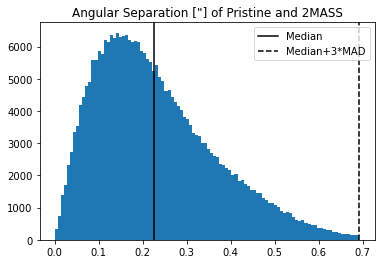

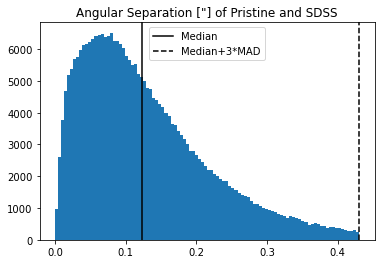

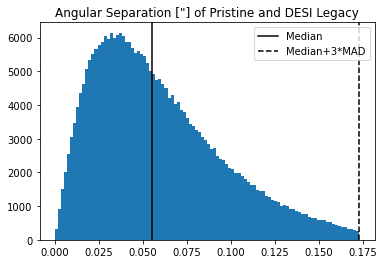

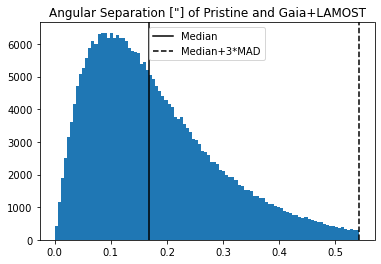

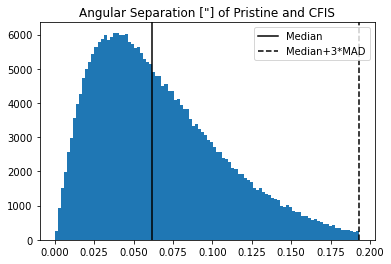

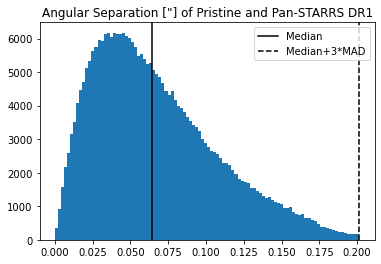

In [52]:
for it,sep in enumerate(seps):    
    # Creating the histogram of the separation values
    histo = plt.hist(mdata[sep[0]],bins=100)
    plt.title('Angular Separation [\"] of Pristine and '+sep[1])
    # Determining the median
    plt.axvline(meds[it],c='k',label='Median')
    # Determining the Median Absolute Deviation
    plt.axvline(meds[it]+3*mads[it],c='k',linestyle='dashed',label=r'Median+3*MAD')
    plt.legend(fancybox=True)
    plt.show()

Now the data table "mdata" should have values that were cross-matched and are within 3 MAD of the median

lets save this table as its own thing then for easy importing in the future.

In [53]:
newhdu = fits.BinTableHDU(mdata)
newhdu.writeto('/arc/home/aydanmckay/phottable-x-lamost-post-edit.fits',overwrite=True)

In [54]:
len(mdata)

283834

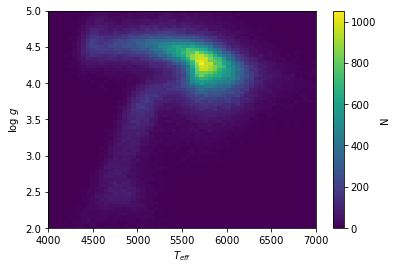

In [60]:
plt.scatter(mdata['TEFF_PASTEL'],mdata['LOGG_PASTEL'],c=mdata['FEH_PASTEL'])
plt.hist2d(mdata['TEFF_PASTEL'],mdata['LOGG_PASTEL'],bins=250)
c = plt.colorbar()
plt.xlabel(r'$T_{eff}$')
plt.ylabel(r'log $g$');
c.set_label('N')
plt.xlim(4000,7000)
plt.ylim(2,5)
plt.savefig('kieldiaghist.png')

In [56]:
# max(mdata['TEFF_PASTEL'])

In [15]:
hdul = fits.open('/arc/projects/k-pop/catalogues/lamost-dr8-gaiaedr3.fits')
lamost = hdul[1].data

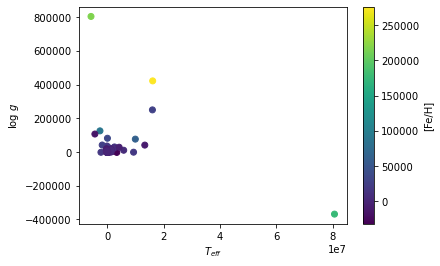

In [16]:
plt.scatter(lamost['TEFF_PASTEL'],lamost['LOGG_PASTEL'],c=lamost['FEH_PASTEL'])
c = plt.colorbar()
plt.xlabel(r'$T_{eff}$')
plt.ylabel(r'log $g$');
c.set_label('[Fe/H]')
plt.savefig('kieldiaglamostnocuts.png')

In [17]:
lamost.columns

ColDefs(
    name = 'obsid'; format = 'D'
    name = 'ra_obs'; format = 'D'
    name = 'dec_obs'; format = 'D'
    name = 'FEH_APOGEE'; format = 'D'
    name = 'MH_APOGEE'; format = 'D'
    name = 'CH_APOGEE'; format = 'D'
    name = 'NH_APOGEE'; format = 'D'
    name = 'CFE_APOGEE'; format = 'D'
    name = 'NFE_APOGEE'; format = 'D'
    name = 'AFE_APOGEE'; format = 'D'
    name = 'LOGG_APOGEE'; format = 'D'
    name = 'TEFF_PASTEL'; format = 'D'
    name = 'LOGG_PASTEL'; format = 'D'
    name = 'FEH_PASTEL'; format = 'D'
    name = 'A_GG'; format = 'D'
    name = 'A_BP'; format = 'D'
    name = 'A_RP'; format = 'D'
    name = 'A_J'; format = 'D'
    name = 'A_H'; format = 'D'
    name = 'A_KS'; format = 'D'
    name = 'A_W1'; format = 'D'
    name = 'A_W2'; format = 'D'
    name = 'A_BAP'; format = 'D'
    name = 'A_VAP'; format = 'D'
    name = 'A_RAP'; format = 'D'
    name = 'A_GSD'; format = 'D'
    name = 'A_RSD'; format = 'D'
    name = 'A_ISD'; format = 'D'
    name = 'snrg'; 

In [18]:
lamostmasked = lamost[(lamost['snrg'] > 20) & (lamost['visibility_periods_used'] > 8) & \
                      (lamost['astrometric_chi2_al']/(lamost['astrometric_n_good_obs_al']-5) < 1.44*np.exp(-0.4*(lamost['phot_g_mean_mag']-19.5))) & \
                      (lamost['astrometric_chi2_al']/(lamost['astrometric_n_good_obs_al']-5) < 1.44) & (lamost['TEFF_PASTEL'] > 4000) & (lamost['TEFF_PASTEL'] < 7500) & \
                      (lamost['parallax_over_error'] > 5) & (lamost['FEH_PASTEL'] < 5) & (lamost['LOGG_PASTEL'] < 5) & (lamost['LOGG_PASTEL'] > 0)]

LAMOST: We require that SNR > 20 in u, g, r, i or z band, and that qflag chi2 == ‘good’ and flag singlestar == ‘YES’.

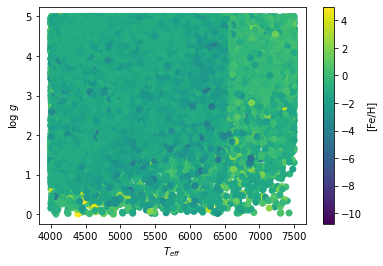

In [19]:
plt.scatter(lamostmasked['TEFF_PASTEL'],lamostmasked['LOGG_PASTEL'],c=lamostmasked['FEH_PASTEL'])
c = plt.colorbar()
plt.xlabel(r'$T_{eff}$')
plt.ylabel(r'log $g$');
c.set_label('[Fe/H]')

In [20]:
np.unique(lamost['flag_feh_pastel'])

array([0., 1.])